# 案例分析(2) —— Google 股票走势预测

# 1、谷歌（Google Inc.）

- 成立时间
    - 1998 年 9 月 4 日
- 创始人
    - Larry Page && Sergey Mikhaylovich Brin
- 标签
    - 全球最大的搜索引擎公司
    - 业务包括互联网搜索、云计算、广告技术、互联网产品与服务等
    - 《2018 世界品牌 500 强》Google 排名第 2 位

# 2、Google 股票预测

## 2.1 Quandl

- 针对金融投资行业的大数据平台
- 数据来源
    - 500 多家发布商
    - 联合国、世界银行、中央银行等公开数据
    - CLS 集团，Zacks 和 ICE 等
- [官网](https://www.quandl.com/)

## 2.2 所需模块

#### (1) quandl
- 提供 Python 接口，用来获取 Quandl 上的数据
- 安装
    - pip install quandl

## 2.3 导入模块

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

import quandl

## 2.4 准备数据

- WIKI/GOOGL
    - 数据集的ID
    - 旧版本接口提供的数据，不需要提供身份信息
    - 新版本的 Quandl 要求用户在其网站 [注册](https://www.quandl.com/sign-up-modal?defaultModal=showSignUp) 获取身份信息，然后利用身份信息才能读取数据

- df
    - DataFrame 对象

#### (1) 获取 Google 股票数据

In [2]:
df = quandl.get('WIKI/GOOGL')  # 可能要等半分钟左右，如果报措，重新运行即可

#### (2) 查看数据

- 美股的参数含义
    - Open 开盘价
    - High 最高价
    - Low 最低价
    - Close 收盘价
    - Volume 成交量
    - Ex-Dividend 除息（Exclude Dividend除去利息）
    - Split Ratio 分割比率
    - Adj. Open 除权后的开盘价

In [3]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [4]:
df.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1092.57,1108.70,1087.21,1094.00,1990515.0,0.0,1.0,1092.57,1108.70,1087.21,1094.00,1990515.0
2018-03-22,1080.01,1083.92,1049.64,1053.15,3418154.0,0.0,1.0,1080.01,1083.92,1049.64,1053.15,3418154.0
2018-03-23,1051.37,1066.78,1024.87,1026.55,2413517.0,0.0,1.0,1051.37,1066.78,1024.87,1026.55,2413517.0
2018-03-26,1050.60,1059.27,1010.58,1054.09,3272409.0,0.0,1.0,1050.60,1059.27,1010.58,1054.09,3272409.0
2018-03-27,1063.90,1064.54,997.62,1006.94,2940957.0,0.0,1.0,1063.90,1064.54,997.62,1006.94,2940957.0


In [5]:
len(df)

3424

## 2.5 缺失数据

#### (1) 判断是否有缺失数据
```Python
>>> df.isna().any()
```

In [5]:
df.isna().any()

Open           False
High           False
Low            False
Close          False
Volume         False
Ex-Dividend    False
Split Ratio    False
Adj. Open      False
Adj. High      False
Adj. Low       False
Adj. Close     False
Adj. Volume    False
dtype: bool

- 说明没有缺失数据

## 2.6 预处理数据

- 研究对象
    - 除权后的收盘价 Adj. Close
- 特征选择原则
    - 可能影响股票价格的变量（需要专业知识）
- 本次分析的特征选择
    - 特征 1：股票最高价与最低价的变化百分比
    - 特征 2：股票收盘价与开盘价的变化百分比
    - 特征 3：成交量
    - 特征 4：多天前的收盘价

#### (1) 构造新列，补充特征1、2

In [6]:
def percentChange(s1, s2):
    '''计算变化的百分比'''
    return (s1 - s2) / s2 * 100

In [7]:
googleDF = df.copy()

In [8]:
# 股票最高价与最低价的变化百分比
googleDF['High2LowPercent'] = percentChange(googleDF['Adj. High'], googleDF['Adj. Low'])

# 股票收盘价与开盘价的变化百分比
googleDF['Close2OpenPercent'] = percentChange(googleDF['Adj. Close'], googleDF['Adj. Open'])

googleDF.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,High2LowPercent,Close2OpenPercent
Date,,,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0,8.441017,0.324968
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0,8.537313,7.227007
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0,4.062357,-1.227880
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0,7.753210,-5.726357
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0,3.966115,1.183658


#### (2) 保留用得到的特征字段

In [9]:
googleDF = googleDF[['Adj. Close', 'High2LowPercent', 'Close2OpenPercent', 'Adj. Volume']]
googleDF.tail()

,Adj. Close,High2LowPercent,Close2OpenPercent,Adj. Volume
Date,,,,
2018-03-21,1094.00,1.976619,0.130884,1990515.0
2018-03-22,1053.15,3.265882,-2.487014,3418154.0
2018-03-23,1026.55,4.089299,-2.360729,2413517.0
2018-03-26,1054.09,4.818025,0.332191,3272409.0
2018-03-27,1006.94,6.707965,-5.353887,2940957.0


#### (3) 训练集

In [23]:
predCol = 'Adj. Close'
predNum = math.ceil(len(googleDF)*0.01)
predCol, predNum

('Adj. Close', 35)

- 把 99% 的数据用做训练集

In [24]:
googleDF['y'] = googleDF[predCol].shift(-predNum)  
googleDF
# shift函数是对数据进行移动的操作
# 长线预测，比如持有1个月

,Adj. Close,High2LowPercent,Close2OpenPercent,Adj. Volume,y
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,69.078238
2004-08-20,54.322689,8.537313,7.227007,22834300.0,67.839414
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,3.966115,1.183658,9188600.0,71.219849
2004-08-26,54.122070,3.143512,2.820391,7094800.0,72.278116
2004-08-27,53.239345,2.772258,-1.803885,6211700.0,74.810934
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,74.199045
2004-08-31,51.343492,1.517228,0.048866,4917800.0,70.462511


In [37]:
X = np.array(googleDF.drop(['y'], 1))
X = preprocessing.scale(X)  # 对 X 的数据进行规范化处理
X = X[ :-predNum]           # 训练集
X_pred = X[-predNum: ]      # 预测数据

In [38]:
y = np.array(googleDF[['y']].dropna())  # dropna使用dropna使得滤除缺失数据更加得心应手。
y

array([[  69.0782379 ],
       [  67.83941377],
       [  68.91272699],
       ...,
       [1026.55      ],
       [1054.09      ],
       [1006.94      ]])

In [39]:
googleDF[['y']].shape, y.shape

((3424, 1), (3389, 1))

In [40]:
len(X), len(X_pred), len(y)

(3389, 35, 3389)

In [35]:
# y = np.array(googleDF['Adj. Close'])
# googleDF['Adj. Close']

Date
2004-08-19      50.322842
2004-08-20      54.322689
2004-08-23      54.869377
2004-08-24      52.597363
2004-08-25      53.164113
2004-08-26      54.122070
2004-08-27      53.239345
2004-08-30      51.162935
2004-08-31      51.343492
2004-09-01      50.280210
2004-09-02      50.912161
2004-09-03      50.159839
2004-09-07      50.947269
2004-09-08      51.308384
2004-09-09      51.313400
2004-09-10      52.828075
2004-09-13      53.916435
2004-09-14      55.917612
2004-09-15      56.173402
2004-09-16      57.161452
2004-09-17      58.926902
2004-09-20      59.864797
2004-09-21      59.102444
2004-09-22      59.373280
2004-09-23      60.597057
2004-09-24      60.100525
2004-09-27      59.313094
2004-09-28      63.626409
2004-09-29      65.742942
2004-09-30      65.000651
                 ...     
2018-02-13    1054.140000
2018-02-14    1072.700000
2018-02-15    1091.360000
2018-02-16    1095.500000
2018-02-20    1103.590000
2018-02-21    1113.750000
2018-02-22    1109.900000
2018-02

## 2.7 线性回归

#### (1) 分割训练集和测试集

In [41]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

#### (2) 线性回归器

In [42]:
reg = LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### (3) 用测试集评估准确性

In [43]:
accuracy = reg.score(X_test, y_test)
accuracy

0.9781977690760061

#### (4) 预测新数据

In [44]:
reg.predict(X_pred)

array([[1076.93590178],
       [1091.1562225 ],
       [1104.78324309],
       [1099.47487347],
       [1093.04453508],
       [1090.83189396],
       [1089.43218776],
       [1085.75675434],
       [1079.95088099],
       [1075.52596369],
       [1073.58900592],
       [1092.43559981],
       [1110.90083587],
       [1115.93761413],
       [1130.58942744],
       [1134.79250891],
       [1132.97061184],
       [1130.74779399],
       [1132.42611316],
       [1150.35434511],
       [1149.77578521],
       [1159.25973414],
       [1155.92262384],
       [1164.15907187],
       [1184.20381311],
       [1197.03414058],
       [1190.92223767],
       [1202.92924263],
       [1207.64620801],
       [1207.1412351 ],
       [1197.93249285],
       [1202.77146206],
       [1201.64508858],
       [1137.14952738],
       [1082.57250066]])

## 2.8 绘制走势

#### (1) 修改matplotlib样式

- 灰底白线
- 同学们可以自由发挥

In [45]:
style.use('ggplot')

#### (2) 原走势 vs 原走势 + 新预测

In [52]:
googleDF['pred'] = np.nan
googleDF['pred'][-predNum:] = googleDF['Adj. Close'][-predNum:]
googleDF.tail()

,Adj. Close,High2LowPercent,Close2OpenPercent,Adj. Volume,y,pred
Date,,,,,,
2018-03-21,1094.00,1.976619,0.130884,1990515.0,NaN,1094.00
2018-03-22,1053.15,3.265882,-2.487014,3418154.0,NaN,1053.15
2018-03-23,1026.55,4.089299,-2.360729,2413517.0,NaN,1026.55
2018-03-26,1054.09,4.818025,0.332191,3272409.0,NaN,1054.09
2018-03-27,1006.94,6.707965,-5.353887,2940957.0,NaN,1006.94


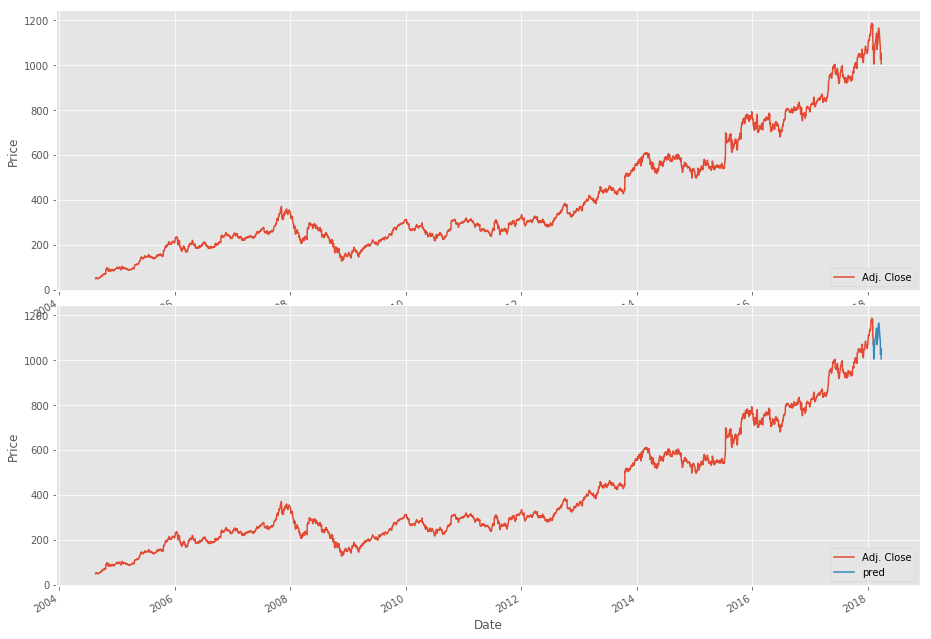

In [47]:
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

fig.add_subplot(2,1,1)
googleDF['Adj. Close'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')

fig.add_subplot(2,1,2)
googleDF['Adj. Close'][:-predNum].plot()
googleDF['pred'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

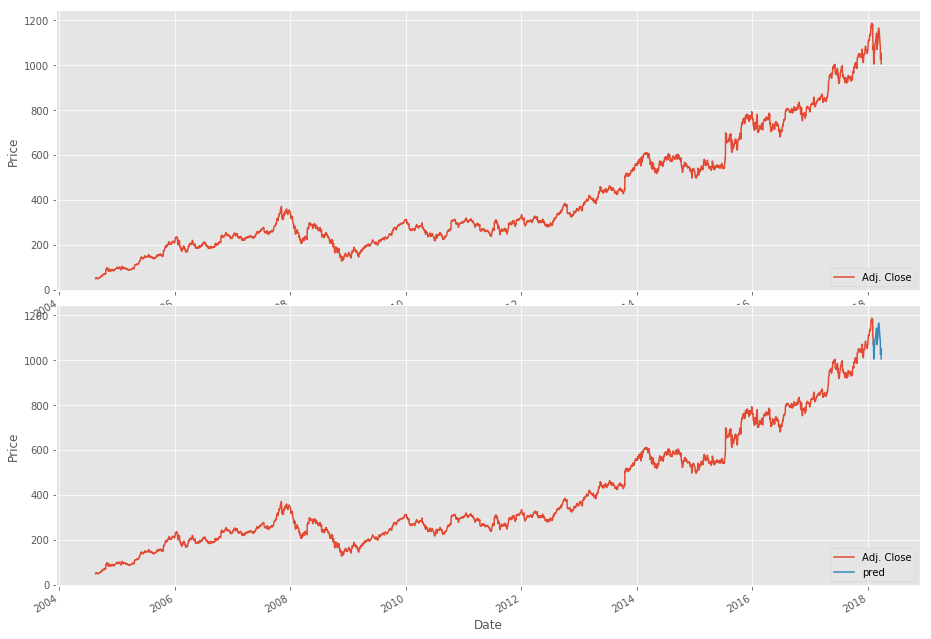

In [51]:
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

fig.add_subplot(2,1,1)
googleDF['Adj. Close'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')

fig.add_subplot(2,1,2)
googleDF['Adj. Close'][:-predNum].plot()
googleDF['pred'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

## 案例分析(2) 结束